In [6]:
import matplotlib.pyplot as plt

from data_loader import *


data = Data(bird_name='American Goldfinch', group_n='10')

,Download_grp,SPECIES_NAME,cnt
SPECIES_ID,,,
5290,10,American Goldfinch,1593352


In [2]:
data.bird

NameError: name 'data' is not defined

In [94]:
def season(df):
    return df.index.month % 12 // 3 + 1


def grab_summer_winter(bird, year:int = None):
    if year:
        df = bird[bird.index.year==year]
        df['season'] = season(df)
        mask = (season(df) ==1)  # | (season(df) ==3)
        return df[mask]
    else:
        df = bird[(bird.index.year>=2000) & (bird.index.year <2020)]
        mask = (season(df) == 1)  # | (season(bird) == 3)
        df['season'] = season(df)
        return df[mask]

from scipy.interpolate import interp2d
from scipy.ndimage import gaussian_filter, rank_filter
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram

def heatmap(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

def interp(x, y):
    bounds = [x.min(), x.max(), y.min(), y.max()]
    f = interp2d(x, y, dens, kind="linear")
    x_coords = np.arange(bounds[0],bounds[1])
    y_coords = np.arange(bounds[2],bounds[3])
    Z = f(x_coords,y_coords)
    return Z, bounds

def compute_rank(intervals):
    # intervals = [1, 7], [2, 9], [3, 11], [5, 10], [5, 9]
    # display(intervals)
    ranks = {}
    # for eta in np.arange(0,2000, 10):
    for eta in np.arange(0,20, 4):
        display(eta)
        for interval in intervals:
            i, j = interval
            # i = 4
            # j = 8
            if i <= eta and j >= eta+4:
                if eta in ranks:
                    ranks[eta] += 1
                else:
                    ranks[eta] = 1

    display(ranks)

year1 = grab_summer_winter(data.bird, 2017)
year2 = grab_summer_winter(data.bird, 2018)

/var/folders/kf/j1jq_1qs78n4gd1vczc8vfw80000gn/T/ipykernel_62240/690917109.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/kf/j1jq_1qs78n4gd1vczc8vfw80000gn/T/ipykernel_62240/690917109.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
year1.shape

(5429, 7)

In [23]:
year2.shape

(4539, 7)

0.02011715567132435

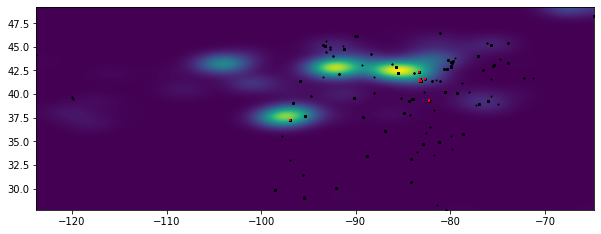

(1, 2876, 2)

array([[[0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.00000000e+00, 1.34869913e-06, 0.00000000e+00],
        [0.000

In [81]:
import numpy as np
from scipy import stats
fig, ax = plt.subplots(figsize=(10, 10))
homo = None
for i, gp in year1.groupby('season'):
    gp.sort_index(inplace=True)
    x = gp.lon.values
    y = gp.lat.values

    # KDE
    positions = np.vstack([x, y])
    kernel = stats.gaussian_kde(positions)
    dens = kernel(positions)

    # Density Estimation
    hm, bounds = heatmap(x, y, 32)    # Gaussian Image Filter
    # heatmap, bounds = interp(x, y)    # 2D interpolation

    plt.imshow(hm.T, extent=bounds, origin='lower')
    # Overlay Raw data
    plt.scatter(x, y, c='k', s=1)
    display(max(dens))
    max_value = dens.max()
    test = gp[dens > max_value - max_value*.20]
    test.to_csv('test{}.csv'.format(i))
    plt.scatter(test.lon.values, test.lat.values, c='r', marker='+', s=8)
    plt.show()

    # PERSIM
    gp['t'] = gp.index - gp.index.min()
    gp.t = gp.t.astype(int) * 1.15741e-14
    # X = np.stack([gp.lat.values, gp.lon.values])
    X = np.vstack([gp.lat.values, gp.lon.values])
    x = np.expand_dims(X.T, axis=0)
    display(x.shape)
    homology_dimensions = [0, 1]

    persistence = VietorisRipsPersistence(
        metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=1
    )
    homo = persistence.fit_transform(x)
    display(persistence.fit_transform_plot(x))
    break

In [98]:
def compute_rank(intervals):
    # display(intervals)
    ranks_0 = {0:0,  3:0,  6:0,  9:0, 12:0, 15:0, 18:0, 21:0, 24:0}
    # ranks_0 = {0: 0, 4: 0, 8:0, 12:0, 16:0,  20:0, 24:0}
    # ranks_1 = {0: 0, 4: 0, 8:0, 12:0, 16:0,  20:0, 24:0}

    # for eta in np.arange(0,2000, 10):
    for eta in np.arange(0,25, 3):
        for interval in intervals:
            # display(interval)
            i, j, k = interval
            if i <= eta and j >= eta+3:
                if k==0:
                    ranks_0[eta] += 1
                # if k==1:
                    # if eta in ranks_1:
                    # ranks_1[eta] += 1
                    # else:
                    #     ranks_1[eta] = 1
            # break
        # break

    display('B0')
    display(ranks_0)
    # display('B1')
    # display(ranks_1)
    return ranks_0.values()

intervals = [1, 7, 0], [2, 9, 0], [3, 11, 0], [5, 10, 0], [5, 9, 0]

compute_rank(intervals)

'B0'

{0: 0, 3: 3, 6: 4, 9: 0, 12: 0, 15: 0, 18: 0, 21: 0, 24: 0}

dict_values([0, 3, 4, 0, 0, 0, 0, 0, 0])

In [99]:
from time import time

t1= time()

compute_rank(homo[0])

t2 = time()

display(t2-t1)

'B0'

{0: 8, 3: 3, 6: 2, 9: 0, 12: 0, 15: 0, 18: 0, 21: 0, 24: 0}

0.01251220703125

In [ ]:
homology_dimensions = [0]
t = list(range(2000, 2020, 1))
vectors = []
for y in t:
    display(y)
    df = grab_summer_winter(data.bird, y)
    X = np.vstack([df.lat.values, df.lon.values])
    x = np.expand_dims(X.T, axis=0)
    persistence = VietorisRipsPersistence(
    metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=1
    )
    homo = persistence.fit_transform(x)
    vectors.append(compute_rank(homo[0]))


In [106]:
M = np.array([list(i) for i in vectors]).T

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


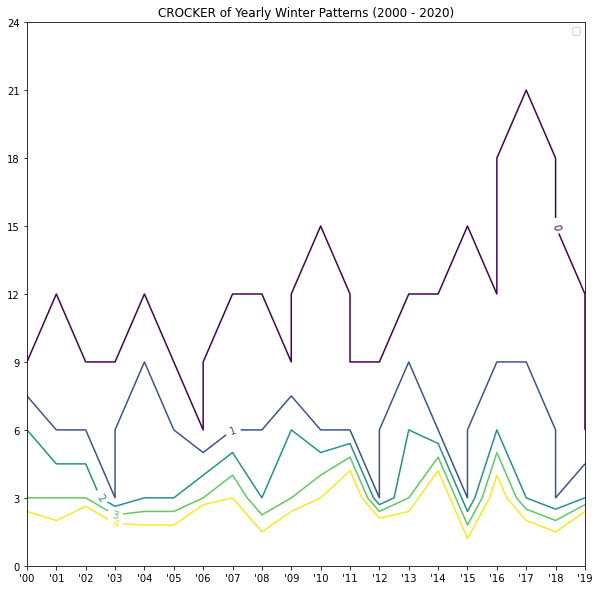

In [135]:
plt.figure(figsize=(10, 10))


contour = plt.contour(M, levels=[0, 1, 2, 3, 4])  # , origin='upper')
plt.clabel(contour, inline=1, fontsize=10)

plt.xticks(range(20), ["'00", "'01", "'02", "'03", "'04", "'05", "'06", "'07", "'08", "'09", "'10", "'11","'12" ,"'13", "'14", "'15", "'16", "'17", "'18", "'19"])

plt.yticks(range(9), ['0', '3', '6', '9', '12', '15', '18', '21', '24'])
# plt.yticks(range(9), np.arange(0,25, 3))
# labels = ['level 1', 'level 2','level 3','level 4']
# for i in range(len(labels)):
#     contour.collections[i].set_label(labels[i])


plt.legend(loc='upper right')

plt.title('CROCKER of Yearly Winter Patterns (2000 - 2020)')

plt.savefig('crocker.png')


In [108]:
M

array([[ 8,  6, 11,  9,  7,  7, 13, 10,  6,  8,  7, 11, 11,  8,  9,  6,
        12,  8,  7, 12],
       [ 3,  3,  3,  1,  2,  2,  3,  4,  2,  3,  4,  6,  1,  3,  6,  1,
         5,  2,  1,  2],
       [ 2,  1,  1,  1,  2,  1,  0,  1,  1,  2,  1,  1,  1,  2,  1,  1,
         2,  2,  1,  0],
       [ 0,  1,  0,  0,  1,  0,  0,  1,  1,  0,  1,  0,  0,  1,  1,  1,
         1,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,
         0,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])

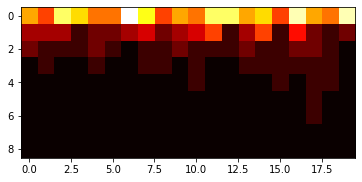

In [109]:
plt.imshow(M, cmap='hot', interpolation='nearest')
plt.show()